This is my first attempt in building Word2Vec model, with inspiration from "What's Cooking" challenge on Kaggle.
If you like it please upvote. Expert reviews/comments or suggestions are welcomed.

In [1]:
import pandas as pd
import numpy as np
import collections
import gensim 
from gensim.models import word2vec, phrases
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short
from textblob import TextBlob, Word

import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import os
from SourceCode.Config.config import BASE_DIR

In [2]:

#load the recipes dataset
filepath = os.path.join(BASE_DIR, 'DAO/data/recipes.csv')
df_recipes = pd.read_csv(filepath, encoding="ISO-8859-1")

#drop rows where cuisine, ingregients are NA
df_recipes.dropna(subset=['cuisine', 'ingredients'],inplace=True)
df_recipes

,id,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients
0,Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4.0,3600.0,NaN,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b..."
1,Peanut-butter-fudge-297693,Peanut Butter Fudge,4.0,8100.0,[Desserts],[American],"[Country Crock® Spread, light corn syrup, crea..."
2,Buckeyes-298471,Buckeyes,4.0,6600.0,[Desserts],[American],"[Skippy® Super Chunk® Peanut Butter, Country C..."
3,Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4.0,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper..."
4,Classic-macaroni-salad-304692,Classic Macaroni Salad,4.0,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m..."
...,...,...,...,...,...,...,...
5469,Chicken-Teriyaki-573526,Chicken Teriyaki,4.0,2700.0,[Main Dishes],[Japanese],"[chicken thighs, light soy sauce, mirin, sake,..."
5470,Miso-Soup-1225759,Miso Soup,4.0,600.0,[Soups],[Japanese],"[dashi, miso, silken tofu, wakame, green onion..."
5471,Miso-Marinated-Pork-_butaniku-no-misozuke_-751346,Miso Marinated Pork (butaniku no misozuke),4.0,2400.0,[Main Dishes],[Japanese],"[pork cutlets, white miso, red miso, fresh gin..."
5472,Japanese-Street-Food-Recipe---Chicken-Karaage-...,Japanese Street Food Recipe - Chicken Karaage,4.0,2700.0,[Main Dishes],"[Japanese, Asian]","[chicken legs, sake, soy sauce, ginger, potato..."


In [3]:
#convert to lower case
df_recipes['ingredients'] = df_recipes['ingredients'].apply(lambda x: x.lower())

total_ingredients = []
all_receipes_ingredients =  []

for i in range(len(df_recipes)):
    all_ingredients = list()
    
    #split each recipe into different ingredients
    ingred = df_recipes.loc[i, "ingredients"][1:-1]
    
    for ing in (ingred.split(',')):
        ing = remove_stopwords(ing)
        ing = strip_numeric(ing)
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing)
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        
        #convert plurals to singular e.g. tomatoes --> tomato
        ing = (" ".join(TextBlob(ing).words.singularize()))
        
        all_ingredients.append(ing)
        total_ingredients.append(ing)
        
    all_receipes_ingredients.append(all_ingredients)
    
counts_ingr = collections.Counter(total_ingredients)

print('Total Ingredients (with repetition):  \t{}'.format((len(total_ingredients))))
print('Unique Ingredients : \t\t\t{}'.format((len(counts_ingr.values()))))
print('Total Receipes:  \t\t\t{}'.format((len(all_receipes_ingredients))))


Total Ingredients (with repetition):  	55047
Unique Ingredients : 			2633
Total Receipes:  			5474


In [4]:
#add cleaned ingredients back to original dataframe
df_recipes['clean_ingredients'] = pd.Series(all_receipes_ingredients)

#record the number of ingredients for each recipe
df_recipes['ingredient_count'] =  df_recipes.apply(lambda row: len(row['clean_ingredients']), axis = 1)

#convert time in seconds to minutes
df_recipes['timeMins'] = df_recipes.totalTimeInSeconds.apply(lambda x: x/60) 

In [5]:
print(np.mean(list(counts_ingr.values())))
print(np.std(list(counts_ingr.values())))
print(np.median(list(counts_ingr.values())))
print(np.percentile(list(counts_ingr.values()), [25., 50., 75., 99.]))

20.906570451955943
99.1628173432985
2.0
[  1.     2.     7.   378.36]


In [6]:
#find the most common ingredients used across all recipes
print ("---- Most Common Ingredients ----")
print (counts_ingr.most_common(10))

print ("\n")

#find the most common ingredients used across all recipes
print ("---- Least Common Ingredients ----")
print (counts_ingr.most_common()[-10:])


---- Most Common Ingredients ----
[('salt', 2377), ('onion', 1794), ('garlic', 1484), ('pepper', 1208), ('butter', 1160), ('black pepper', 1020), ('sugar', 1019), ('olive oil', 897), ('water', 881), ('egg', 845)]


---- Least Common Ingredients ----
[('orecchiette', 1), ('gorgonzola', 1), ('ciabattum bun', 1), ('bertolli', 1), ('liquid egg substitute', 1), ('delallo extra virgin olive oil', 1), ('sourdough baguette', 1), ('mentsuyu', 1), ('canola oil cooking spray', 1), ('wakame', 1)]


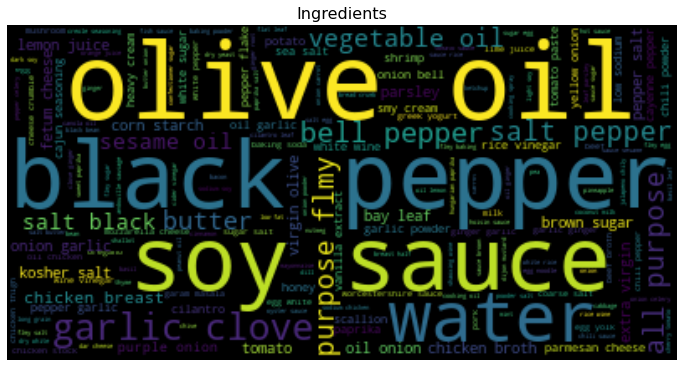

In [7]:
#visualize the ingredients in WordCloud 

from wordcloud import WordCloud

def plot_wordcloud(text, title=None, max = 1000, size=(12,8), title_size=16):
    """plots wordcloud"""
    wordcloud = WordCloud(max_words=max).generate(text)
    plt.figure(figsize=size)
    plt.title(title, size=title_size)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plot_wordcloud(' '.join(total_ingredients), title='Ingredients')

In [8]:
#Train the Word2Vec model

num_features = 300    # Word vector dimensionality                      
min_word_count = 4                        
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 

downsampling = 1e-2   # threshold for configuring which 
                      # higher-frequency words are randomly downsampled
            
# Initialize and train the model 
model = word2vec.Word2Vec(all_receipes_ingredients, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context,sample = downsampling, iter=20)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [9]:
# check the similar ingredients returned by the model for search_terms

similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['paneer','egg','mango','bread', 'rice']}
similar_words

{'paneer': ['masala',
  'chile powder',
  'coriander powder',
  'garlic paste',
  'ginger paste'],
 'egg': ['beaten egg', 'egg white', 'egg yolk', 'sprinkle', 'dough'],
 'mango': ['light rum', 'club soda', 'mint leaf', 'mint', 'lime juice'],
 'bread': ['italian cheese blend',
  'part skim mozzarella cheese',
  'pepperoni',
  'chee mozzarella',
  'monterey jack cheese'],
 'rice': ['extra firm tofu',
  'beansprout',
  'white rice',
  'jasmine rice',
  'brown rice']}

In [ ]:
#visualization with Tsne
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
model.wv.most_similar_cosmul(positive=['paneer', u'chicken'], negative=['tomato sauce'])

In [ ]:
model.wv.most_similar('chocolate')

In [ ]:
model.wv.most_similar('mayonnaise')

In [ ]:
model.wv.most_similar('chicken')

In [ ]:
model.wv.similarity('paneer', 'chicken')

In [ ]:
model.wv.doesnt_match("chicken paneer lentils meat".split())

In [ ]:
model.wv.similarity('chocolate', 'cream')

In [ ]:
x = 'bread'
b= 'cheese'
a = 'bread'
predicted = model.wv.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

In [ ]:
plt.style.available
plt.style.use('ggplot')

plt.xlabel('Cooking Time (minutes)')
plt.ylabel('Recipe Count')

labels = ['4', '3', '5', '0', '2', '1']
plt.pie(df_recipes.rating.value_counts(), labels=labels, autopct='%1.1f%%', colors=['gold', 'green', 'lightcoral', 'lightskyblue', 'red'], startangle=50, pctdistance=0.6)
plt.axis('equal')
plt.title('Recipes by Rating')
plt.show()

In [ ]:
# ingredient/rating relationship?

feature_cols = ['ingredient_count']
X= df_recipes[feature_cols]
y= df_recipes.rating
plt.scatter(X, y)
plt.xlabel('Ingredients')
plt.ylabel('Yummly Rating')
plt.title('Ingredient Counts vs Ratings')

In [ ]:
feature_cols = ['timeMins']
X= df_recipes.dropna()[feature_cols]
y= df_recipes.dropna().rating
plt.scatter(X, y)
plt.xlabel('Time in Minutes')
plt.ylabel('Yummly Rating')
plt.title('Cooking Time vs Ratings')


In [ ]:
# ingredients/cooking time relationship?
feature_cols = ['ingredient_count']
X= df_recipes.dropna()[feature_cols]
y= df_recipes.dropna()['timeMins']
plt.scatter(X, y)
plt.xlabel('Ingredient Count')
plt.ylabel('Time in Minute')
plt.title('Ingredients vs. Cooking Times')


In [ ]:
df_indian = df_recipes[df_recipes.cuisine.str.contains("indian", case=False)].copy()

ingredients =df_indian["clean_ingredients"].sum()

counts = collections.Counter(ingredients)

counts.most_common(30)


In [ ]:
from Config.config import BASE_DIR

In [ ]:
# save model
model.wv.save_word2vec_format(os.path.join(BASE_DIR, 'DAO/data/w2vmodel'))